# CNN Klasyfikujący obrazy płuc 


In [29]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd




Utworzenie scieżki do danych

In [30]:
dataset_path = "dataset"

Utworzenie zmiennch koniecznych do podziału danych przy pomocy funkcji z biblioteki keras

In [31]:
batch_size = 64
img_height = 128
img_width = 128

Dzielenie danych na grupy trenujące i walidacyjne

In [32]:
train_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.


In [33]:
val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,   
    validation_split=0.2,
    subset="validation",    
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


### Prefetching danych

Aby poprawić wydajność procesu uczenia, używam funkcji `prefetch`, która umożliwia wstępne ładowanie danych w tle, podczas gdy model jest trenowany na obecnej partii danych. 

- `tf.data.AUTOTUNE` pozwala TensorFlow dynamicznie dostosować liczbę wątków do optymalnego ładowania danych.
- Użycie `prefetch` pomaga uniknąć "czekania" na dane i umożliwia równoczesne ładowanie nowych danych podczas trenowania modelu, co skraca czas potrzebny na trenowanie.

In [34]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Przykładowe dane
Zdjęcia przedstawiają 3 kategorie: 
- Gruczolakorak
- Zdrowe płuca
- Rak kolczystokomórkowy

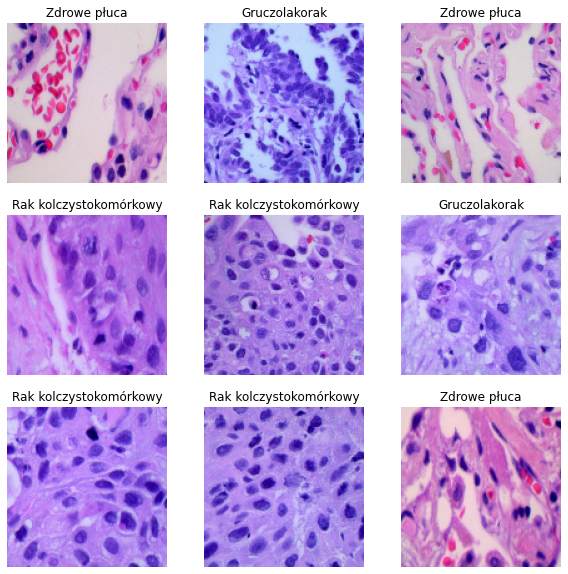

In [35]:
labels = ["Gruczolakorak", "Zdrowe płuca", "Rak kolczystokomórkowy"]  # Zmień na nazwy swoich klas, jeśli są inne


plt.figure(figsize=(10,10))
for images, num_labels in train_ds.take(1):
    for x in range(9):
        ax = plt.subplot(3, 3, x+1)
        plt.imshow(np.array(images[x]).astype('uint8'))
        label_text = labels[int(num_labels[x])]
        plt.title(label_text)
        plt.axis('off')

### Tworzenie modelu CNN (Convolutional Neural Network)

W tej komórce tworzony jest model sieci konwolucyjnej (CNN) do klasyfikacji obrazów. Model składa się z kilku warstw konwolucyjnych i max pooling, a także kilku warstw gęstych (fully connected), aby przewidywać klasy na podstawie obrazów.

1. **Wejście do modelu**: 
   - `keras.Input(shape=(128, 128, 3))` określa kształt obrazu wejściowego, który będzie miał wymiary 128x128 pikseli oraz 3 kanały (RGB).

2. **Warstwa augmentacji (RandomRotation)**:
   - `layers.RandomRotation(0.1)` wprowadza losową rotację obrazów o maksymalnie 10%, co pomaga w poprawie generalizacji modelu.

3. **Reskalowanie obrazów**:
   - `layers.Rescaling(scale=1./255)` normalizuje obrazy, dzieląc wartości pikseli przez 255, aby przekształcić je na zakres [0, 1].

4. **Warstwy konwolucyjne (Conv2D)**:
   - Pierwsza warstwa konwolucyjna (`layers.Conv2D`) posiada 32 filtry o rozmiarze 3x3 oraz funkcję aktywacji ReLU. Zastosowano `padding="same"`, co oznacza, że obraz wyjściowy ma takie same wymiary jak wejściowy.
   - Kolejna warstwa konwolucyjna z 64 filtrami o rozmiarze 3x3 również z paddingiem "same".

5. **Warstwy max pooling (MaxPooling2D)**:
   - Warstwy `layers.MaxPooling2D(pool_size=(2, 2))` stosują pooling z rozmiarem okna 2x2, zmniejszając wymiary obrazów i zachowując tylko najważniejsze cechy.

6. **Flatten**:
   - `layers.Flatten()` spłaszcza wyjście z warstw konwolucyjnych i poolingowych do jednowymiarowego wektora, który może zostać podany do warstwy gęstej.

7. **Warstwy gęste (Dense)**:
   - Pierwsza warstwa gęsta (`layers.Dense(64, activation="relu")`) ma 64 jednostki i stosuje funkcję aktywacji ReLU.
   - Druga warstwa gęsta (`layers.Dense(3, activation="softmax")`) posiada 3 jednostki, odpowiadające 3 klasom, i stosuje funkcję aktywacji Softmax, aby uzyskać prawdopodobieństwa dla każdej z klas.

8. **Kompilacja modelu**:
   - Model jest kompilowany z optymalizatorem `adam` i funkcją straty `sparse_categorical_crossentropy`, ponieważ jest to problem klasyfikacji wieloklasowej. Zastosowano również metrykę dokładności (`accuracy`).



In [36]:
from keras.regularizers import l2
model = keras.Sequential()


model.add(keras.Input(shape=(128, 128, 3)))
# model.add(layers.RandomFlip("horizontal"))
model.add(layers.RandomRotation(0.1))
#model.add(layers.RandomZoom(0.1))
#model.add(layers.RandomBrightness(0.1))

model.add(layers.Rescaling(scale = 1./255))

model.add(layers.Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    padding="same",
    
))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    padding="same",
    
))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# model.add(layers.Conv2D(
#     filters = 64,
#     kernel_size = (3, 3),
#     padding="same",
    
# ))

# model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# model.add(layers.Conv2D(
#     filters = 128,
#     kernel_size = (5, 5),
#     padding="same",
    
# ))

# model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(3, activation="softmax"))


model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### Użycie Callback'u: `EarlyStopping`

W tej komórce kodu tworzę obiekt callback, który będzie wykorzystywany w trakcie treningu modelu:

**`EarlyStopping`**:
   - Callback `EarlyStopping` jest wykorzystywany do monitorowania postępów modelu w trakcie treningu, w celu przerwania treningu, gdy model przestaje się poprawiać.
   - Parametry:
     - `monitor='val_accuracy'`: Monitoruje dokładność na zbiorze walidacyjnym (nie na treningowym).
     - `patience=5`: Określa liczbę epok, w których model nie może poprawić swojej dokładności na zbiorze walidacyjnym, zanim trening zostanie przerwany. W tym przypadku po 5 epokach bez poprawy zatrzymamy trening.
     - `restore_best_weights=True`: Po przerwaniu treningu, model zostanie przywrócony do stanu, w którym osiągnął najlepszy wynik na zbiorze walidacyjnym (nawet jeśli później dokładność zacznie maleć).
   
Dzięki temu, mogę monitorować efektywność modelu i przerwać trening, jeśli dalsze trenowanie nie poprawia wyników.


In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='my_model.keras',  # Gdzie zapisać model
    monitor='val_accuracy',  # Monitorujemy dokładność na zbiorze walidacyjnym
    save_best_only=True,  # Zapisujemy tylko najlepszy model
    mode='max',  # Chcemy maksymalizować val_accuracy
    verbose=1  # Wypisuje informacje o zapisie modelu
)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, 
                               restore_best_weights=True)


# Wizualizacja wyników treningu modelu

Poniższy kod przedstawia wykresy pokazujące dokładność oraz stratę modelu w trakcie treningu i walidacji w zależności od liczby epok.


Epoch 1/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6878 - loss: 0.9949
Epoch 1: val_accuracy improved from -inf to 0.63233, saving model to my_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 264ms/step - accuracy: 0.6882 - loss: 0.9927 - val_accuracy: 0.6323 - val_loss: 0.8259
Epoch 2/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7950 - loss: 0.4363
Epoch 2: val_accuracy improved from 0.63233 to 0.83367, saving model to my_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 265ms/step - accuracy: 0.7951 - loss: 0.4361 - val_accuracy: 0.8337 - val_loss: 0.3581
Epoch 3/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8536 - loss: 0.3294
Epoch 3: val_accuracy improved from 0.83367 to 0.86967, saving model to my_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 264ms/step - accuracy: 0.8536 - loss: 0.3294 - val_accuracy: 0.8697 - val_loss: 0.3023
Epoch 4/64
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8655 - loss: 0.3056
Epoch 4: val_accuracy improved

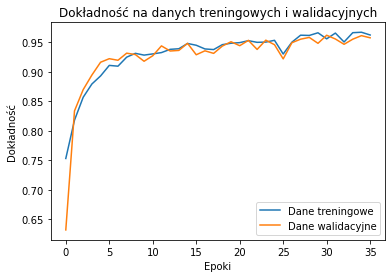

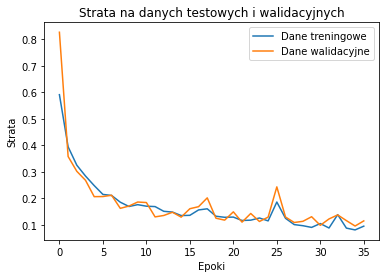

In [38]:
import matplotlib.pyplot as plt
history = model.fit(train_ds, epochs=64, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])


# Get accuracy values from the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']  
# Plot training and validation accuracy
plt.plot(train_acc, label='Dane treningowe')
plt.plot(val_acc, label='Dane walidacyjne')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Dokładność na danych treningowych i walidacyjnych')
plt.legend(loc='lower right')
plt.show()

plt.plot(train_loss, label='Dane treningowe')
plt.plot(val_loss, label='Dane walidacyjne')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Strata na danych testowych i walidacyjnych')
plt.legend(loc='upper right')
plt.show()

## Macierz błędu

In [39]:
y_true = []  # Prawdziwe etykiety
y_pred = []  # Przewidywania modelu


for images, labels in val_ds:
    y_true.extend(labels.numpy())

    predictions = model.predict(images)  # Predykcje modelu dla danej partii obrazów
    
    predicted_labels = np.argmax(predictions, axis=1)  # Przewidywana klasa (z indeksu o najwyższym prawdopodobieństwie)
    
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Prawdziwe etykiety:", y_true[:10])
print("Predykcje modelu:", y_pred[:10]) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

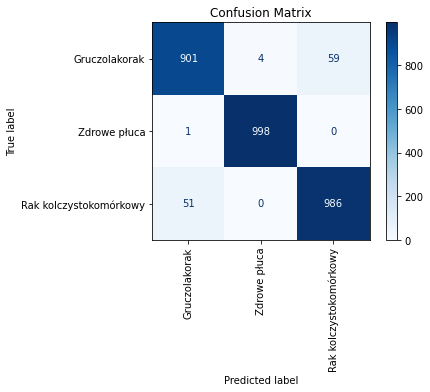

In [41]:
labels = ["Gruczolakorak", "Zdrowe płuca", "Rak kolczystokomórkowy"]  # Zmień na nazwy swoich klas, jeśli są inne

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

Macierz błędu pokazuje, że model miał najwiekszy problem z rozróżnianiem gruczkolakoraka i raka kolczystokomórkowego

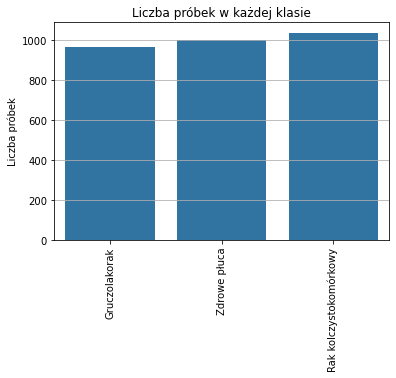

In [42]:
labels = []
for images, label_batch in val_ds:
    labels.extend(label_batch.numpy())

labels = np.array(labels)

true_labels = ["Gruczolakorak", "Zdrowe płuca", "Rak kolczystokomórkowy"]
sns.countplot(x=labels)
plt.title('Liczba próbek w każdej klasie')

plt.xticks(ticks=np.arange(len(true_labels)), labels=true_labels, rotation=90)
plt.ylabel('Liczba próbek')
plt.grid(axis='y')
plt.show()

In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

## Model pretrenowany `VGG16`

In [44]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Zamrożenie wag w warstwach pretrenowanych, aby nie były aktualizowane podczas treningu
for layer in base_model.layers:
    layer.trainable = False

# Dodaj własne warstwy na końcu modelu
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Utwórz nowy model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Kompilacja modelu
model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_vgg16 = model_vgg16.fit(train_ds, epochs=64, validation_data=val_ds, callbacks=early_stopping)

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.8538 - loss: 2.5417 - val_accuracy: 0.9627 - val_loss: 0.1583
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9661 - loss: 0.1676 - val_accuracy: 0.9623 - val_loss: 0.1910
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9841 - loss: 0.0600 - val_accuracy: 0.9620 - val_loss: 0.1794
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9880 - loss: 0.0467 - val_accuracy: 0.9703 - val_loss: 0.1474
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.9885 - loss: 0.0374 - val_accuracy: 0.9727 - val_loss: 0.1373


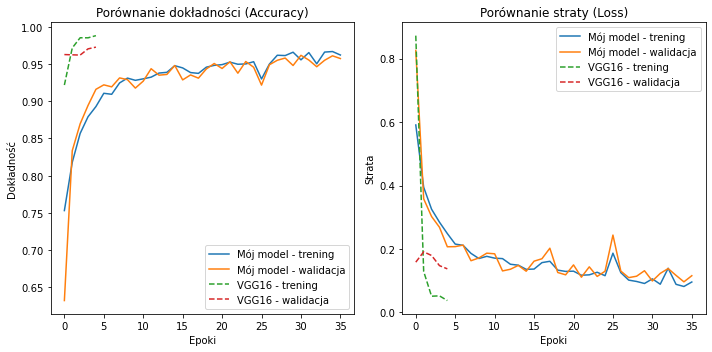

In [46]:
# Wykres porównujący dokładność Twojego modelu z VGG16
train_acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
train_acc_my_model = history.history['accuracy']
val_acc_my_model = history.history['val_accuracy']

plt.figure(figsize=(10, 5))

# Dokładność
plt.subplot(1, 2, 1)
plt.plot(train_acc_my_model, label='Mój model - trening')
plt.plot(val_acc_my_model, label='Mój model - walidacja')
plt.plot(train_acc_vgg16, label='VGG16 - trening', linestyle='--')
plt.plot(val_acc_vgg16, label='VGG16 - walidacja', linestyle='--')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Porównanie dokładności (Accuracy)')
plt.legend()

# Strata
train_loss_my_model = history.history['loss']
val_loss_my_model = history.history['val_loss']
train_loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(train_loss_my_model, label='Mój model - trening')
plt.plot(val_loss_my_model, label='Mój model - walidacja')
plt.plot(train_loss_vgg16, label='VGG16 - trening', linestyle='--')
plt.plot(val_loss_vgg16, label='VGG16 - walidacja', linestyle='--')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Porównanie straty (Loss)')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
print(f"Dokładność mojego modelu na zbiorze walidacyjnym: {val_acc_my_model[-1]:.4f}")
print(f"Dokładność modelu VGG16 na zbiorze walidacyjnym: {val_acc_vgg16[-1]:.4f}")


Dokładność mojego modelu na zbiorze walidacyjnym: 0.9573
Dokładność modelu VGG16 na zbiorze walidacyjnym: 0.9727
